# Predicción mediante LSTM 






In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from pylab import rcParams
from sklearn.metrics import mean_squared_error
import tensorflow as tf

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

## Cargamos la data

In [ ]:
csv_path = "Data_2.csv"

In [ ]:
dfx = pd.read_csv(csv_path, sep=';')
dfx

,year,month,day,ALLSKY_SFC_SW_DWN
0,2010,1,1,4.26
1,2010,1,2,7.00
2,2010,1,3,6.45
3,2010,1,4,7.60
4,2010,1,5,6.84
...,...,...,...,...
4072,2021,2,24,7.29
4073,2021,2,25,7.25
4074,2021,2,26,7.36
4075,2021,2,27,6.30


In [ ]:
dfx['time(UTC)'] = pd.to_datetime(dfx[['year','month','day']])

In [ ]:
dfx.columns

Index(['year', 'month', 'day', 'ALLSKY_SFC_SW_DWN', 'time(UTC)'], dtype='object')

In [ ]:
df = dfx[['time(UTC)','ALLSKY_SFC_SW_DWN']]

In [ ]:
df = df.drop(df[df['ALLSKY_SFC_SW_DWN']<0].index)

In [ ]:
#df = pd.read_csv(csv_path, parse_dates=['time(UTC)'])
#df = df.sort_values('time(UTC)')
#df.head()

In [ ]:
df.shape

(4045, 2)

In [ ]:
df.set_index('time(UTC)', inplace = True)

In [ ]:
df

,ALLSKY_SFC_SW_DWN
time(UTC),
2010-01-01,4.26
2010-01-02,7.00
2010-01-03,6.45
2010-01-04,7.60
2010-01-05,6.84
...,...
2021-02-24,7.29
2021-02-25,7.25
2021-02-26,7.36


Text(0, 0.5, '$G (kW-hr/m^2/day)$')

<Figure size 360x2160 with 0 Axes>

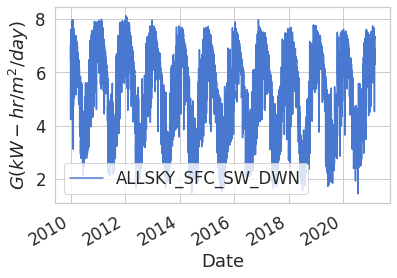

In [ ]:
plt.figure(figsize=(5,30))
ax = df.plot(y='ALLSKY_SFC_SW_DWN');
ax.set_xlabel("Date")
ax.set_ylabel(r'$G (kW-hr/m^2/day)$')

## Days

### Normalization

In [ ]:
scaler = MinMaxScaler()

close_price = df['ALLSKY_SFC_SW_DWN'].values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [ ]:
scaled_close.shape

(4045, 1)

In [ ]:
np.isnan(scaled_close).any()

False

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [ ]:
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
np.isnan(scaled_close).any()

False

### Preprocessing

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.9)

In [ ]:
df.shape

(4045, 1)

In [ ]:
X_train.shape

(3550, 99, 1)

In [ ]:
X_test.shape

(395, 99, 1)

### Model

In [ ]:
model = tf.keras.Sequential()
# adding 1st LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
# adding 2nd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# adding 3rd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# adding 4th LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))
# adding output layer
model.add(tf.keras.layers.Dense(units=1))
#compiling RNN
#model.compile(loss='mean_squared_error', optimizer='adam')
#early_stopping = EarlyStopping(monitor='loss', patience=10)
# fitting RNN on training set
#model.fit(X_train, y_train, epochs= 100, batch_size=32, 
          #verbose=2, callbacks=[early_stopping])
#model.fit(X_train, y_train, epochs= 100, batch_size=32, verbose=2)

### Training

In [ ]:
model.compile(
    loss='mean_squared_error', metrics=['accuracy'],
    optimizer='adam'
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 99, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 99, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 99, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 99, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 99, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [ ]:
BATCH_SIZE = 60

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/100
54/54 [==============================] - 19s 162ms/step - loss: 0.0660 - accuracy: 3.1299e-04 - val_loss: 0.0278 - val_accuracy: 0.0000e+00
Epoch 2/100
54/54 [==============================] - 8s 143ms/step - loss: 0.0273 - accuracy: 3.1299e-04 - val_loss: 0.0241 - val_accuracy: 0.0000e+00
Epoch 3/100
54/54 [==============================] - 8s 146ms/step - loss: 0.0264 - accuracy: 3.1299e-04 - val_loss: 0.0258 - val_accuracy: 0.0000e+00
Epoch 4/100
54/54 [==============================] - 8s 145ms/step - loss: 0.0248 - accuracy: 3.1299e-04 - val_loss: 0.0232 - val_accuracy: 0.0000e+00
Epoch 5/100
54/54 [==============================] - 8s 142ms/step - loss: 0.0235 - accuracy: 3.1299e-04 - val_loss: 0.0229 - val_accuracy: 0.0000e+00
Epoch 6/100
54/54 [==============================] - 8s 142ms/step - loss: 0.0234 - accuracy: 3.1299e-04 - val_loss: 0.0236 - val_accuracy: 0.0000e+00
Epoch 7/100
54/54 [==============================] - 8s 141ms/step - loss: 0.0239 - accuracy:

In [ ]:
model.save('my_model_D.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
#model = load_model('my_model.h5')

In [ ]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 19ms/step - loss: 0.0148 - accuracy: 0.0025


[0.014799460768699646, 0.0025316455867141485]

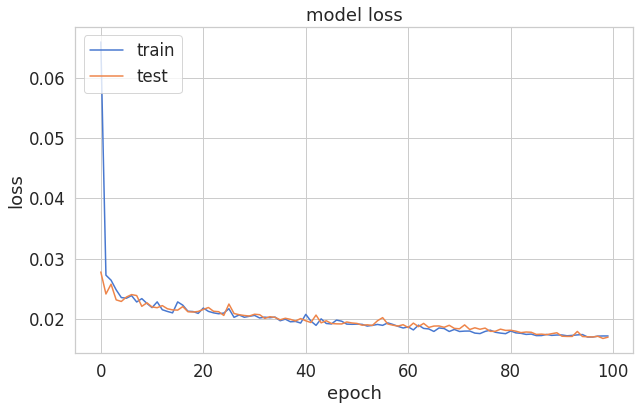

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

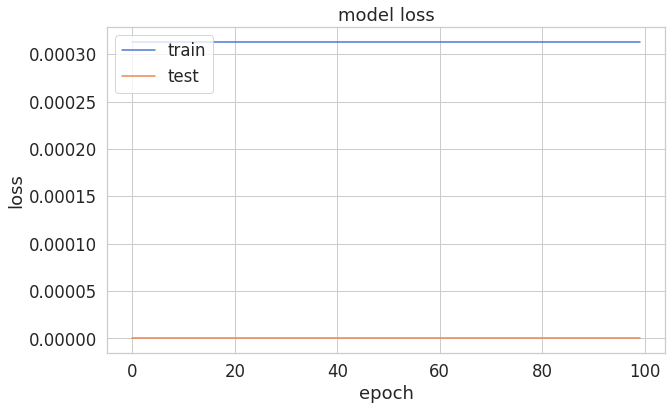

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Prediction

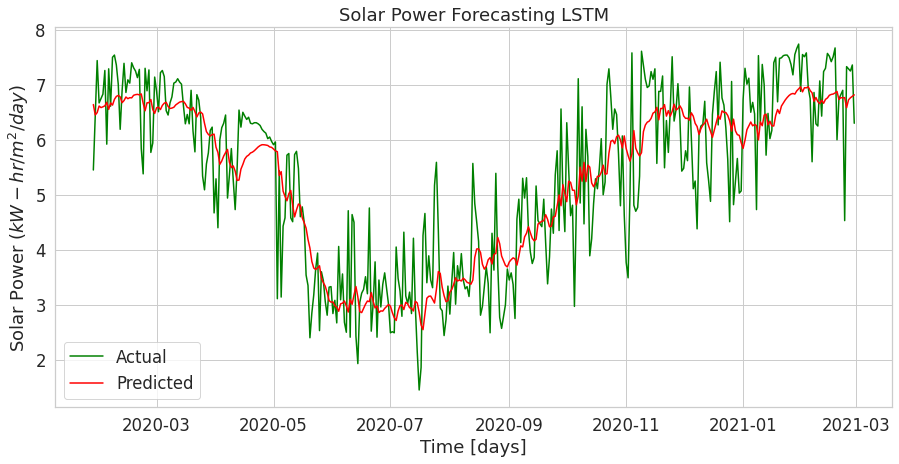

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.figure(figsize=(15,7))
plt.plot(df.index[-len(X_test):],y_test_inverse, label="Actual", color='green')
plt.plot(df.index[-len(X_test):],y_hat_inverse, label="Predicted", color='red')

plt.title('Solar Power Forecasting LSTM')
plt.xlabel('Time [days]')
plt.ylabel(r'Solar Power $(kW-hr/m^2/day)$')
plt.legend(loc='best')
 
plt.show();

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

#plt.figure(figsize=(15,7))
plt.plot(df.index[-len(X_test):],y_test_inverse, label="Actual", color='green')
plt.plot(df.index[-len(X_test):],y_hat_inverse, label="Predicted", color='red')

plt.annotate('Score: 73%', xy=(200, 7),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))

plt.title('Solar Power Forecasting LSTM')
plt.xlabel('Time [days]')
plt.ylabel(r'Solar Power $(kW-hr/m^2/day)$')
plt.legend(loc='best')
 
plt.show();

In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test_inverse,y_hat_inverse)

0.7366377980945416

In [ ]:
rms = mean_squared_error(y_test_inverse,y_hat_inverse, squared=False)
rms

0.8114257760322678

### Prediction with error

In [ ]:
def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    #ax.plot(x, y, color=color)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

In [ ]:
L=len(y_hat_inverse)
x = np.linspace(0, L,L)

In [ ]:
y_hat_inverse[:,0].std()

1.3468032

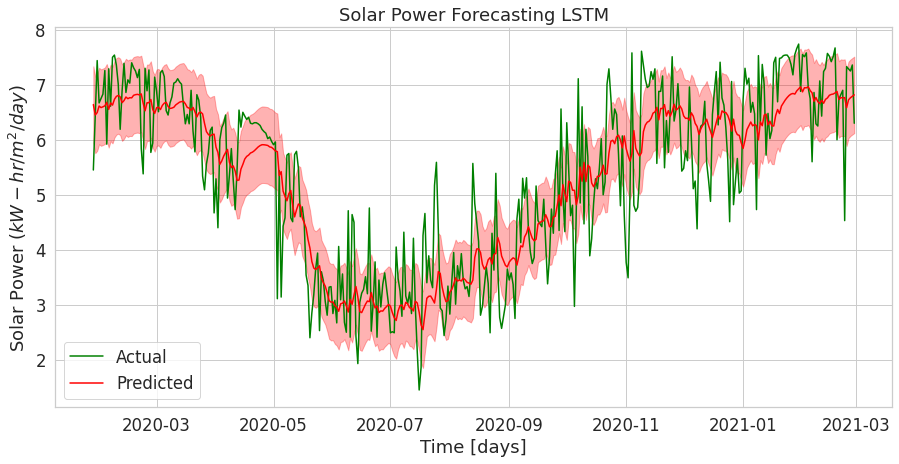

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.figure(figsize=(15,7))
plt.plot(df.index[-len(X_test):],y_test_inverse, label="Actual", color='green')
plt.plot(df.index[-len(X_test):],y_hat_inverse, label="Predicted", color='red')
errorfill(df.index[-len(X_test):],y_hat_inverse[:,0], y_hat_inverse[:,0].std()*.5, color='red')

plt.title('Solar Power Forecasting LSTM')
plt.xlabel('Time [days]')
plt.ylabel(r'Solar Power $(kW-hr/m^2/day)$')
plt.legend(loc='best')
 
plt.show();

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.figure(figsize=(15,7))
plt.plot(df.index[-len(X_test):],y_test_inverse, label="Actual", color='green')
plt.plot(y_hat_inverse, label="Predicted", color='red')
errorfill(x,y_hat_inverse[:,0], y_hat_inverse[:,0].std()*.5, color='red')

plt.annotate('Score: 73%', xy=(200, 7),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))

plt.title('Solar Power Forecasting LSTM')
plt.xlabel('Time [days]')
plt.ylabel(r'Solar Power $(kW-hr/m^2/day)$')
plt.legend(loc='best')
 
plt.show();

## WEEK

In [ ]:
df1 = df.copy()

In [ ]:
df1.set_index('time(UTC)', inplace = True)

In [ ]:
df1.resample('W', label='left')

In [ ]:
opsd_weekly_mean = df1['ALLSKY_SFC_SW_DWN'].resample('W').mean()

In [ ]:
opsd_weekly_mean.index

DatetimeIndex(['2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07', '2010-02-14', '2010-02-21',
               '2010-02-28', '2010-03-07',
               ...
               '2020-12-27', '2021-01-03', '2021-01-10', '2021-01-17',
               '2021-01-24', '2021-01-31', '2021-02-07', '2021-02-14',
               '2021-02-21', '2021-02-28'],
              dtype='datetime64[ns]', name='time(UTC)', length=583, freq='W-SUN')

In [ ]:
df_w = pd.DataFrame(data=opsd_weekly_mean, index=opsd_weekly_mean.index)

In [ ]:
df_w['time(UTC)']=opsd_weekly_mean.index
df_w.reset_index(drop=True, inplace=True)
df_w

,ALLSKY_SFC_SW_DWN,time(UTC)
0,5.903333,2010-01-03
1,6.587143,2010-01-10
2,6.164286,2010-01-17
3,6.981429,2010-01-24
4,6.997143,2010-01-31
...,...,...
578,7.418571,2021-01-31
579,6.790000,2021-02-07
580,7.054286,2021-02-14
581,7.008571,2021-02-21


Text(0, 0.5, '$G (kW-hr/m^2/day)$')

<Figure size 360x2160 with 0 Axes>

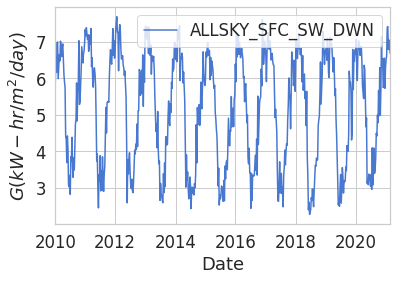

In [ ]:
plt.figure(figsize=(5,30))
ax = df_w.plot(x='time(UTC)', y='ALLSKY_SFC_SW_DWN');
ax.set_xlabel("Date")
ax.set_ylabel(r'$G (kW-hr/m^2/day)$')

Text(0.5, 0, '$G (kW-hr/m^2/day)$')

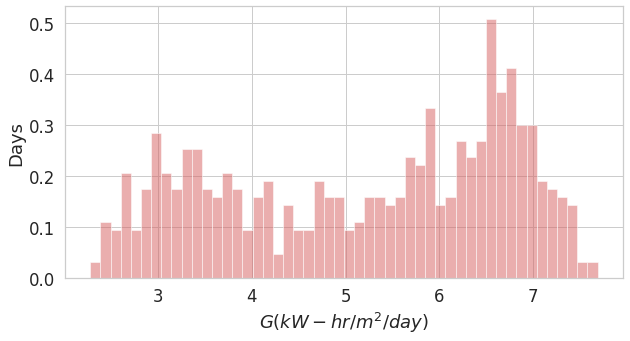

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(df_w['ALLSKY_SFC_SW_DWN'], bins=50, density=True, facecolor='r', alpha=0.5);
plt.ylabel(r"Days")
plt.xlabel(r'$G (kW-hr/m^2/day)$')

### Normalization

In [ ]:
scaler = MinMaxScaler()

close_price = df_w['ALLSKY_SFC_SW_DWN'].values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [ ]:
scaled_close.shape

(583, 1)

In [ ]:
np.isnan(scaled_close).any()

False

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [ ]:
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
np.isnan(scaled_close).any()

False

### Preprocessing

In [ ]:
SEQ_LEN = 50

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.9)

In [ ]:
df_w.shape

(583, 2)

In [ ]:
X_train.shape

(479, 49, 1)

In [ ]:
X_test.shape

(54, 49, 1)

### Model

In [ ]:
model = tf.keras.Sequential()
# adding 1st LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
# adding 2nd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# adding 3rd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# adding 4th LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))
# adding output layer
model.add(tf.keras.layers.Dense(units=1))
#compiling RNN
model.compile(loss='mean_squared_error', optimizer='adam')
#early_stopping = EarlyStopping(monitor='loss', patience=10)
# fitting RNN on training set
#model.fit(X_train, y_train, epochs= 100, batch_size=32, 
          #verbose=2, callbacks=[early_stopping])
#model.fit(X_train, y_train, epochs= 100, batch_size=32, verbose=2)

### Training

In [ ]:
model.compile(
    loss='mean_squared_error', metrics=['accuracy'],
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 60

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/100
8/8 [==============================] - 6s 209ms/step - loss: 0.2547 - accuracy: 0.0023 - val_loss: 0.2121 - val_accuracy: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 1s 77ms/step - loss: 0.1541 - accuracy: 0.0023 - val_loss: 0.1045 - val_accuracy: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 1s 84ms/step - loss: 0.1128 - accuracy: 0.0023 - val_loss: 0.0876 - val_accuracy: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 1s 82ms/step - loss: 0.0948 - accuracy: 0.0000e+00 - val_loss: 0.1033 - val_accuracy: 0.0000e+00
Epoch 5/100
8/8 [==============================] - 1s 75ms/step - loss: 0.0913 - accuracy: 0.0023 - val_loss: 0.0811 - val_accuracy: 0.0000e+00
Epoch 6/100
8/8 [==============================] - 1s 78ms/step - loss: 0.0768 - accuracy: 0.0046 - val_loss: 0.0752 - val_accuracy: 0.0000e+00
Epoch 7/100
8/8 [==============================] - 1s 84ms/step - loss: 0.0769 - accuracy: 0.0000e+00 - val_loss: 0.0713 - val_accu

In [ ]:
model.save('my_model_W.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
#model = load_model('my_model.h5')

In [ ]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 13ms/step - loss: 0.0090 - accuracy: 0.0000e+00


[0.008951805531978607, 0.0]

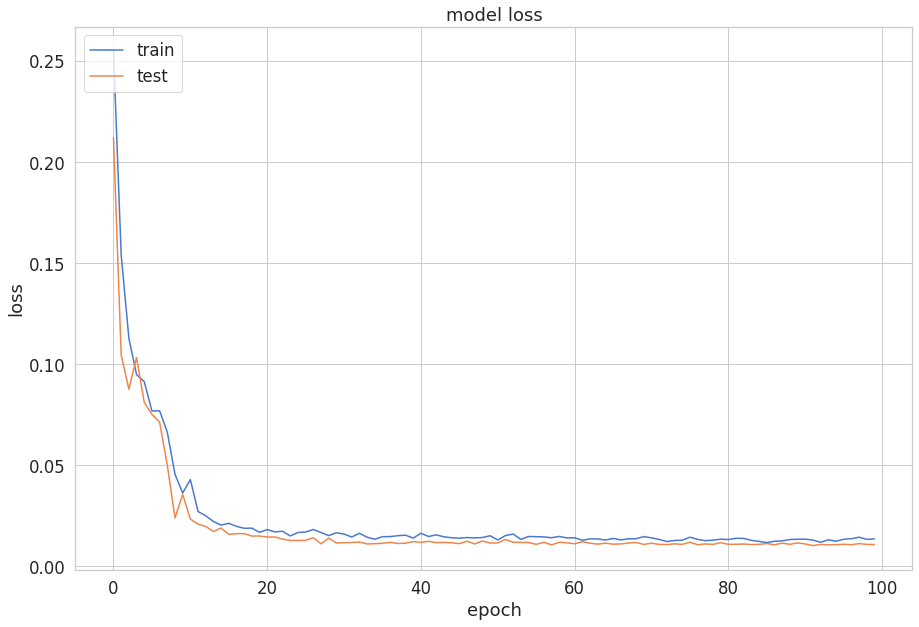

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

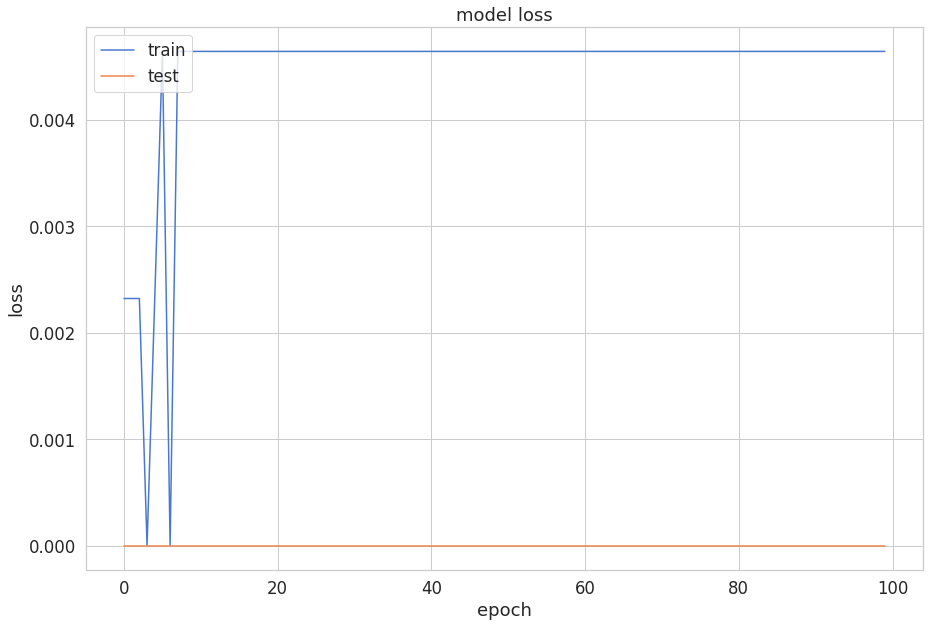

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Prediction

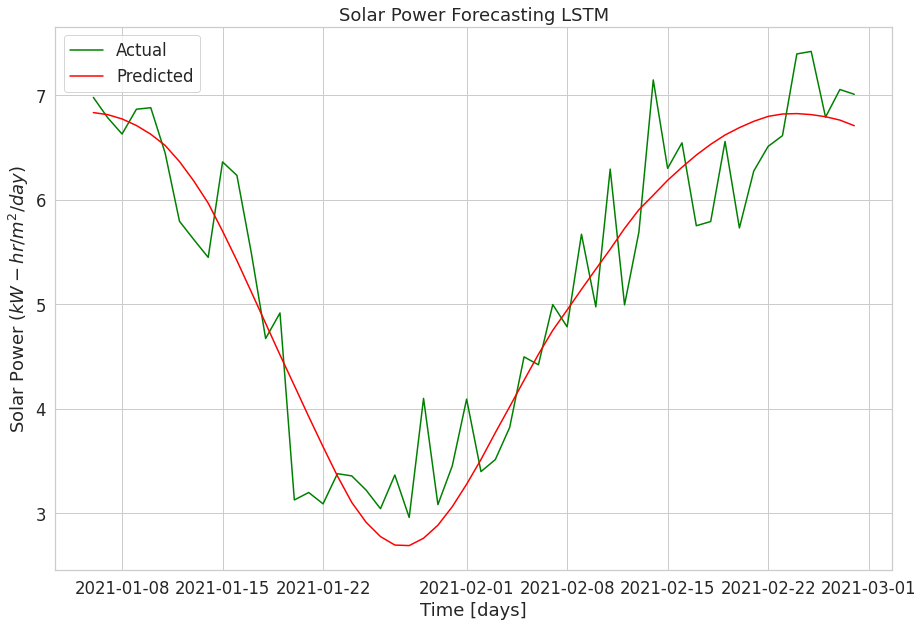

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(df1.index[-len(X_test):],y_test_inverse, label="Actual", color='green')
plt.plot(df1.index[-len(X_test):],y_hat_inverse, label="Predicted", color='red')
#
plt.title('Solar Power Forecasting LSTM')
plt.xlabel('Time [days]')
plt.ylabel(r'Solar Power $(kW-hr/m^2/day)$')
plt.legend(loc='best')
 
plt.show();

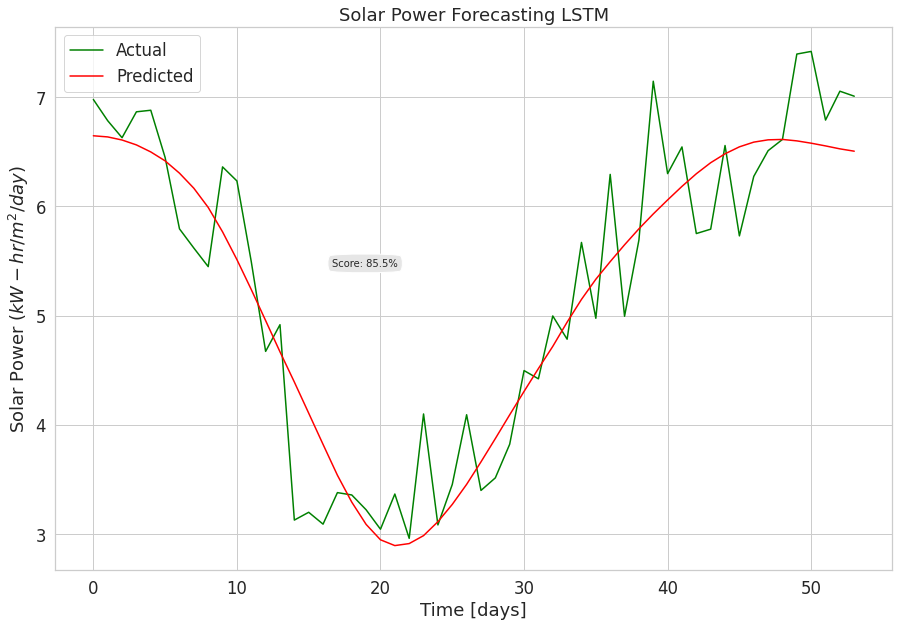

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(y_test_inverse, label="Actual", color='green')
plt.plot(y_hat_inverse, label="Predicted", color='red')
#
plt.annotate('Score: 85.5%', xy=(25, 6),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))

plt.title('Solar Power Forecasting LSTM')
plt.xlabel('Time [days]')
plt.ylabel(r'Solar Power $(kW-hr/m^2/day)$')
plt.legend(loc='best')
 
plt.show();

In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test_inverse,y_hat_inverse)

0.8699388728999129

In [ ]:
rms = mean_squared_error(y_test_inverse,y_hat_inverse, squared=False)
rms

0.5119968253988166

### Prediction with error

In [ ]:
def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    #ax.plot(x, y, color=color, label="Predicted")
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

In [ ]:
L=len(y_hat_inverse)
x = np.linspace(0, L,L)

In [ ]:
y_hat_inverse[:,0].std()

1.304407

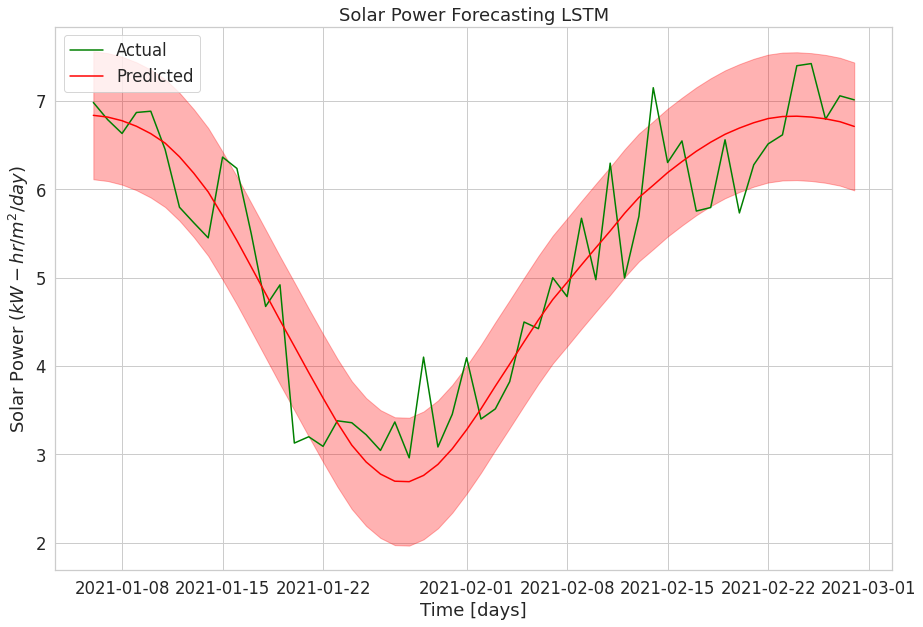

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(df1.index[-len(X_test):],y_test_inverse, label="Actual", color='green')
plt.plot(df1.index[-len(X_test):],y_hat_inverse, label="Predicted", color='red')
errorfill(df1.index[-len(X_test):],y_hat_inverse[:,0], y_hat_inverse[:,0].std()*.5, color='red')
#

plt.title('Solar Power Forecasting LSTM')
plt.xlabel('Time [days]')
plt.xticks(rotation=45)
plt.ylabel(r'Solar Power $(kW-hr/m^2/day)$')
plt.legend(loc='best')
 
plt.show();

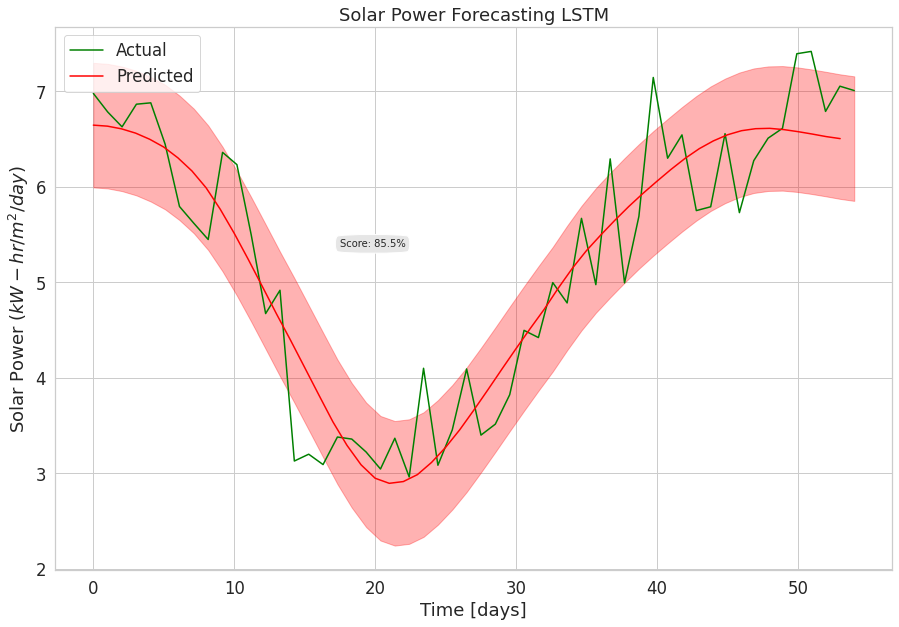

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(x,y_test_inverse, label="Actual", color='green')
plt.plot(y_hat_inverse, label="Predicted", color='red')
errorfill(x,y_hat_inverse[:,0], y_hat_inverse[:,0].std()*.5, color='red')
#
plt.annotate('Score: 85.5%', xy=(26, 6),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))

plt.title('Solar Power Forecasting LSTM')
plt.xlabel('Time [days]')
plt.ylabel(r'Solar Power $(kW-hr/m^2/day)$')
plt.legend(loc='best')
 
plt.show();

## MONTHS

In [ ]:
df2 = df.copy()

In [ ]:
df2.set_index('time(UTC)', inplace = True)

KeyError: ignored

In [ ]:
df2.resample('M', label='left')

In [ ]:
opsd_month_mean = df2['ALLSKY_SFC_SW_DWN'].resample('M').mean()

In [ ]:
opsd_month_mean.index

DatetimeIndex(['2010-01-31', '2010-02-28', '2010-03-31', '2010-04-30',
               '2010-05-31', '2010-06-30', '2010-07-31', '2010-08-31',
               '2010-09-30', '2010-10-31',
               ...
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28'],
              dtype='datetime64[ns]', name='time(UTC)', length=134, freq='M')

In [ ]:
df_m = pd.DataFrame(data=opsd_month_mean, index=opsd_month_mean.index)

In [ ]:
df_m['time(UTC)']=opsd_month_mean.index
df_m.reset_index(drop=True, inplace=True)
df_m

,ALLSKY_SFC_SW_DWN,time(UTC)
0,6.607097,2010-01-31
1,6.353333,2010-02-28
2,6.862903,2010-03-31
3,6.217333,2010-04-30
4,4.262581,2010-05-31
...,...,...
129,5.416129,2020-10-31
130,6.291333,2020-11-30
131,5.929677,2020-12-31
132,6.999355,2021-01-31


Text(0, 0.5, '$G (kW-hr/m^2/day)$')

<Figure size 360x2160 with 0 Axes>

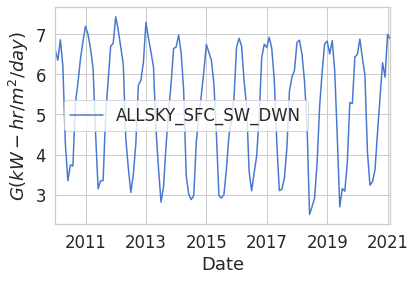

In [ ]:
plt.figure(figsize=(5,30))
ax = df_m.plot(x='time(UTC)', y='ALLSKY_SFC_SW_DWN');
ax.set_xlabel("Date")
ax.set_ylabel(r'$G (kW-hr/m^2/day)$')

Text(0.5, 0, '$G (kW-hr/m^2/day)$')

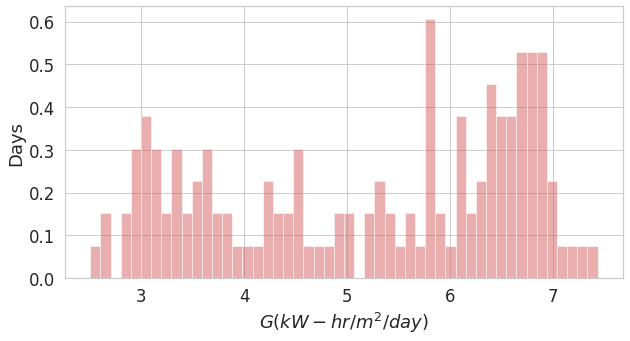

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(df_m['ALLSKY_SFC_SW_DWN'], bins=50, density=True, facecolor='r', alpha=0.5);
plt.ylabel(r"Days")
plt.xlabel(r'$G (kW-hr/m^2/day)$')

### Noralizar

In [ ]:
scaler = MinMaxScaler()

close_price = df_m['ALLSKY_SFC_SW_DWN'].values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [ ]:
scaled_close.shape

(134, 1)

In [ ]:
np.isnan(scaled_close).any()

False

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [ ]:
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
np.isnan(scaled_close).any()

False

### Procesamiento

In [ ]:
SEQ_LEN = 10

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.85)

In [ ]:
df_m.shape

(134, 2)

In [ ]:
X_train.shape

(105, 9, 1)

In [ ]:
X_test.shape

(19, 9, 1)

### Model

In [ ]:
model = tf.keras.Sequential()
# adding 1st LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
# adding 2nd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# adding 3rd LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
# adding 4th LSTM layer and some dropout regularization
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))
# adding output layer
model.add(tf.keras.layers.Dense(units=1))
#compiling RNN
model.compile(loss='mean_squared_error', optimizer='adam')
#early_stopping = EarlyStopping(monitor='loss', patience=10)
# fitting RNN on training set
#model.fit(X_train, y_train, epochs= 100, batch_size=32, 
          #verbose=2, callbacks=[early_stopping])
#model.fit(X_train, y_train, epochs= 100, batch_size=32, verbose=2)

In [ ]:
model.compile(
    loss='mean_squared_error', metrics=['accuracy'],
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 60

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/100
2/2 [==============================] - 5s 971ms/step - loss: 0.3818 - accuracy: 0.0106 - val_loss: 0.3664 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 39ms/step - loss: 0.3355 - accuracy: 0.0106 - val_loss: 0.3164 - val_accuracy: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 0s 39ms/step - loss: 0.2833 - accuracy: 0.0106 - val_loss: 0.2577 - val_accuracy: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 0s 35ms/step - loss: 0.2233 - accuracy: 0.0106 - val_loss: 0.1928 - val_accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 36ms/step - loss: 0.1614 - accuracy: 0.0106 - val_loss: 0.1393 - val_accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 43ms/step - loss: 0.1197 - accuracy: 0.0000e+00 - val_loss: 0.1434 - val_accuracy: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 0s 37ms/step - loss: 0.1372 - accuracy: 0.0106 - val_loss: 0.1556 - val_accuracy

In [ ]:
model.save('my_model_M.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
#model = load_model('my_model.h5')

In [ ]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 16ms/step - loss: 0.0073 - accuracy: 0.0000e+00


[0.007323067635297775, 0.0]

### Plots

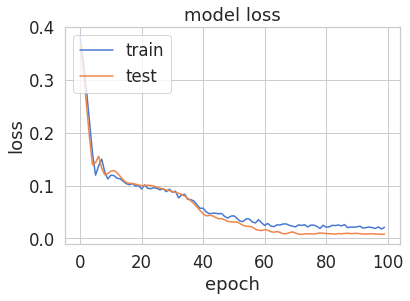

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

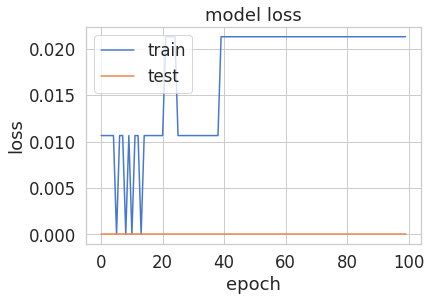

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

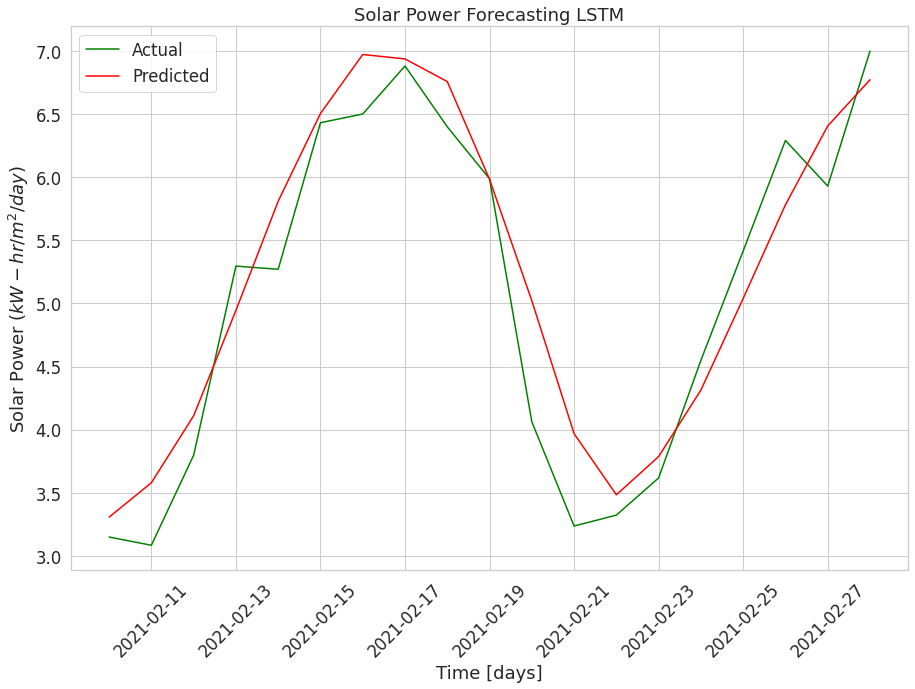

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(df2.index[-len(X_test):],y_test_inverse, label="Actual", color='green')
plt.plot(df2.index[-len(X_test):],y_hat_inverse, label="Predicted", color='red')

plt.title('Solar Power Forecasting LSTM')
plt.xlabel('Time [days]')
plt.xticks(rotation=45)
plt.ylabel(r'Solar Power $(kW-hr/m^2/day)$')
plt.legend(loc='best')
 
plt.show();

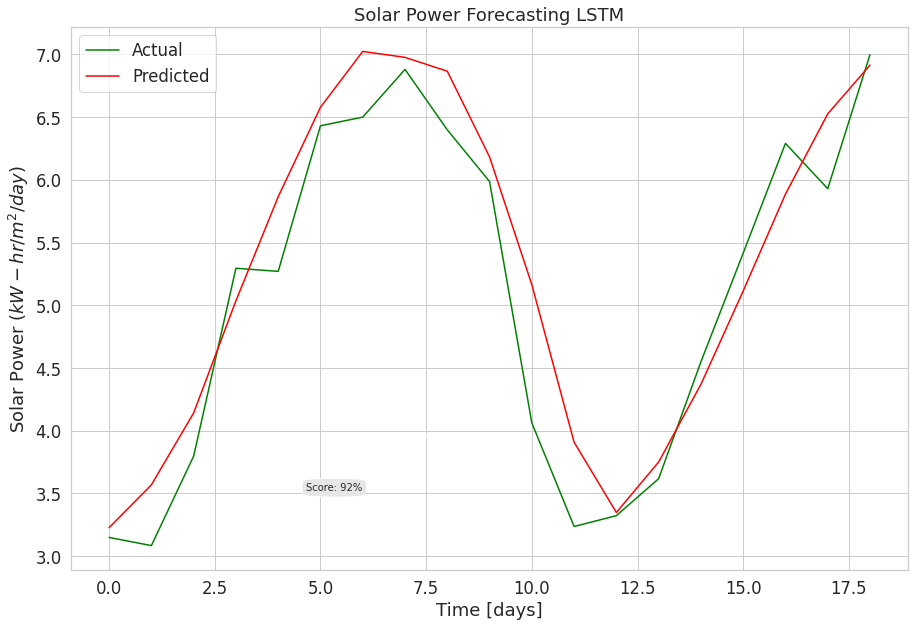

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(y_test_inverse, label="Actual", color='green')
plt.plot(y_hat_inverse, label="Predicted", color='red')
plt.annotate('Score: 92%', xy=(7.5, 4),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))
plt.title('Solar Power Forecasting LSTM')
plt.xlabel('Time [days]')
plt.ylabel(r'Solar Power $(kW-hr/m^2/day)$')
plt.legend(loc='best')
 
plt.show();

In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test_inverse,y_hat_inverse)

0.9033243424283639

In [ ]:
rms = mean_squared_error(y_test_inverse,y_hat_inverse, squared=False)
rms

0.42209054242435784

### plot error

In [ ]:
def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    #ax.plot(x, y, color=color)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

In [ ]:
L=len(y_hat_inverse)
x = np.linspace(0, L,L)

In [ ]:
y_hat_inverse[:,0].std()

1.3219767

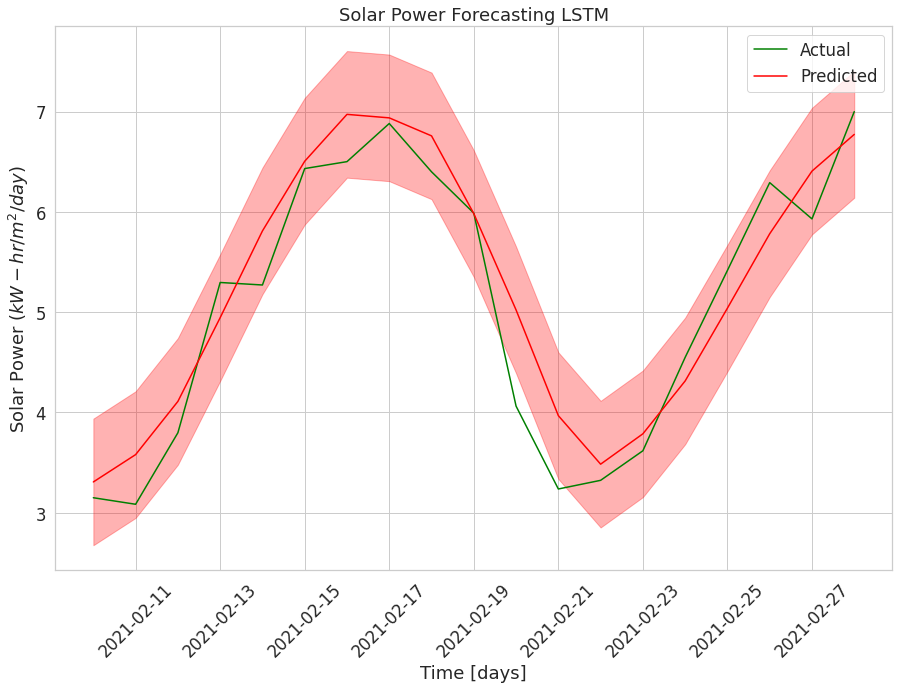

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(df2.index[-len(X_test):],y_test_inverse, label="Actual", color='green')
plt.plot(df2.index[-len(X_test):],y_hat_inverse, label="Predicted", color='red')
errorfill(df2.index[-len(X_test):],y_hat_inverse[:,0], y_hat_inverse[:,0].std()*.5, color='red')

plt.title('Solar Power Forecasting LSTM')
plt.xlabel('Time [days]')
plt.xticks(rotation=45)
plt.ylabel(r'Solar Power $(kW-hr/m^2/day)$')
plt.legend(loc='best')
 
plt.show();

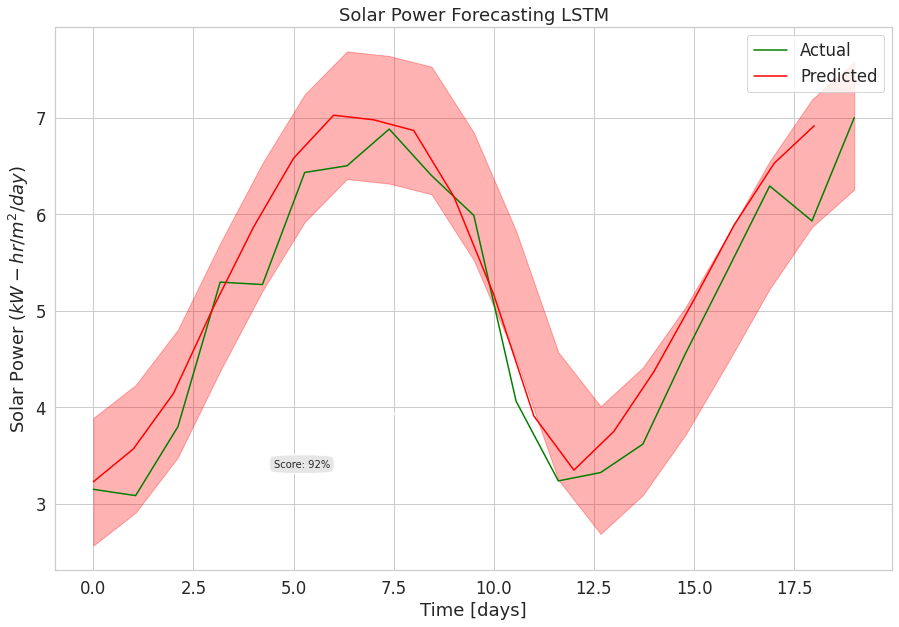

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.figure(figsize=(15,10))
plt.plot(x,y_test_inverse, label="Actual", color='green')
plt.plot(y_hat_inverse, label="Predicted", color='red')
errorfill(x,y_hat_inverse[:,0], y_hat_inverse[:,0].std()*.5, color='red')
plt.annotate('Score: 92%', xy=(7.5, 4),  xycoords='data',
            xytext=(-120, -60), textcoords='offset points',
            bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=80,rad=20"))
plt.title('Solar Power Forecasting LSTM')
plt.xlabel('Time [days]')
plt.ylabel(r'Solar Power $(kW-hr/m^2/day)$')
plt.legend(loc='best')
 
plt.show();

Fin del trabajo!